In [ ]:
'''The way we use NeuralStyleTransfer is by using a model trained on a large Image dataset.
The intermediate layers of this pretrained model works like feature detectors.
We use the output of these intermediate layers(or the intermediate feature detectors) and compare that output with our content image versus a proposed styled image.
This comparison gives us a content cost
Similarly we can use the output of some of the intermediate layers and compare the output with a Style image versus the Styled image.
This comparison gives us a style cost
We then add these 2 costs to get a total cost
We then run an optimization algorithm to minimize this total cost and update the styled image along the way'''

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
#Applying TransferLearning
model=VGG19(
    include_top=False,
    weights='imagenet'
)
# model.trainable=False
for layer in model.layers:
    layer.trainable=False
model.summary()
#last_layer=model.get_layer('block3_conv1')
#print(last_layer.output)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [3]:
#In order to feed data to our model we need to convert data into tensors

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input #Transforms out input image array into a format that our model expects
from tensorflow.keras.models import Model #We use this to instantiate some models based on our VGG19 model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#Processing the input image to make it suitable for our model
def load_and_process_image(image_path):
    img=load_img(image_path)
    img=img_to_array(img)
    img=preprocess_input(img)#Just needed so that our model can understand the image
    img=np.expand_dims(img,axis=0) #The reason we are doing this is because our model expects a 4D tensor and not a normal 3D input image
    return img

In [6]:
#Deprocessing to display the image
#Here we are just reversing the effect of preprocess_input() fxn of the vgg19 
def deprocess(imgArray):
    imgArray[:,:,0]+=103.939
    imgArray[:,:,1]+=116.779
    imgArray[:,:,2]+=123.68
    imgArray=imgArray[:,:,::-1] #For BGR to RGB
    
    imgArray=np.clip(imgArray,0,255).astype('uint8') #This is important to clip the x values between 0 and 255 because the image pixel values lies between these only
    #changing the type to uint8, because it has 8 bits so max value of 255 only
    return imgArray

def display_image(image): #It takes as input a processed image
    if len(image.shape)==4:
        img=np.squeeze(image,axis=0) #This is just the opposite of np.expand_dims() to convert the image from 4D back to 3D, so that we can deprocess it.
        
    img=deprocess(img)
    plt.grid(False)
    plt.xticks([])#No xticks
    plt.yticks([])#No yticks
    plt.imshow(img)
    return #img

In [7]:
#display_image(load_and_process_image('style.jpg'))

In [101]:
#Choosing the Content and style layers
#Read the Notes of AndrewNg for better understanding
content_layer='block5_conv2'

#We choose multiple style layers because we want to check out the style at different points and not just the final style
style_layers=[
    'block1_conv1',
    #'block2_conv1',
    'block3_conv1',
    #'block4_conv1',
    'block5_conv1'
]

#Now to get the activations of these intermediate layers, we create different models with the output as these layers
content_model=Model(
    inputs=model.input,#passing the same input as out vgg19 model
    outputs=model.get_layer(content_layer).output #Gets the output of the layer passed
)
style_models=[Model(inputs=model.input,
                   outputs=model.get_layer(i).output) for i in style_layers]

In [102]:
#Content Cost
def content_cost(content,generated): #Takes in a content image and generated image as input
    a_c=content_model(content) #Activations of the content image
    a_g=content_model(generated)#Activations of the generated image 
    #To know why we did this, just read Andrew Notes
    cost=tf.reduce_mean(tf.square(a_c-a_g)) #This is basically the mean of the squared difference of the activations
    return cost

In [103]:
#StyleMatrix(GramMatrix) We need this for the calculation of StyleCost
def gram_matrix(A): #Takes input a numpy array
    n_c = int(A.shape[-1]) #Number of channels
    a = tf.reshape(A,[-1,n_c])#3D A is convertd to 2D
    #If one component of shape is the special value -1, the size of that dimension is computed so that the total size remains constant. In particular, a shape of [-1] flattens into 1-D. At most one component of shape can be -1.
    n = tf.shape(a)[0] #Gives the number of elements
    G = tf.matmul(a,a,transpose_a=True)#The matrix multiplication of a and a.T
    return G / tf.cast(n,tf.float32) #we scale the gram matrix down by the number of elements

In [104]:
#Style Cost
#It will be the weighted sum of all the style models
weight_list=[0.1,0.1,0.8]
def style_cost(style,generated):
    J_style=0
    
    for i in range(len(style_models)):
        a_s = style_models[i](style)#similar as in content cost
        a_g = style_models[i](generated)
        g_s = gram_matrix(a_s)
        g_g = gram_matrix(a_g)
        current_cost = tf.reduce_mean(tf.square(g_s-g_g))
        J_style += current_cost*weight_list[i]
        
    return J_style



In [105]:
#Note that the total cost is the weighted sum of the content and the style cost

In [106]:
#TrainingLoop
#First we need to initialize the content image, the style image and an initial generated image
#Then we need to instantiate an optimizer, then we run the training loop for a given number of iterations
#For each iteration we compute the total cost, then we're going to calculate the gradients of the cost wrt the generated image using automatic differentiation
#We then update the gradients, we save the lowest cost and the image generated corresponding to the lowest cost

In [107]:
import time #Just to note for how long our loop runs
generated_images=[] #To store the image generated after each iteration

def training_loop(content_path,style_path,iterations=25,alpha=20,beta=10): #alpha and beta are for the weighted total cost
    
    content=load_and_process_image(content_path)
    style=load_and_process_image(style_path)
    generated=tf.Variable(content,dtype=tf.float32) #our starting generated image
    optimizer=tf.keras.optimizers.Adam(learning_rate=8)
    
    best_cost=1e12 + 0.1 #Just setting it to very high
    best_image=None
    
    start_time=time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape: #Read about gradientTape in the documentation
            J_content=content_cost(content,generated)
            J_style=style_cost(style,generated)
            J_total=alpha*J_content + beta*J_style
        grads=tape.gradient(J_total,generated)
        optimizer.apply_gradients([(grads,generated)])
        
        if J_total<best_cost:
            best_cost=J_total
            best_image=generated.numpy() #For converting the tensor into a numpy array
            
        print('Cost after iteration {}: {}. Time elapsed: {}'.format(i,J_total,time.time()-start_time))
        generated_images.append(generated.numpy()) #Appending in numpy form and not in the tensor form
        
    return best_image

In [108]:
best_image=training_loop('content3.jpg','style4.jpg')

Cost after iteration 0: 889348352.0. Time elapsed: 148.80615425109863
Cost after iteration 1: 533638080.0. Time elapsed: 267.78361344337463
Cost after iteration 2: 263219040.0. Time elapsed: 375.2234580516815
Cost after iteration 3: 256679376.0. Time elapsed: 483.31808972358704
Cost after iteration 4: 164660032.0. Time elapsed: 591.1956026554108
Cost after iteration 5: 111058144.0. Time elapsed: 704.5183055400848
Cost after iteration 6: 92615736.0. Time elapsed: 821.4647145271301
Cost after iteration 7: 79473984.0. Time elapsed: 919.6790010929108
Cost after iteration 8: 69937456.0. Time elapsed: 1063.8239207267761
Cost after iteration 9: 61184400.0. Time elapsed: 1237.6155941486359
Cost after iteration 10: 51371952.0. Time elapsed: 1346.7613456249237
Cost after iteration 11: 42684648.0. Time elapsed: 1455.7433333396912
Cost after iteration 12: 35729804.0. Time elapsed: 1576.2835640907288
Cost after iteration 13: 31023224.0. Time elapsed: 1688.9168119430542
Cost after iteration 14: 2835

IndexError: list index out of range

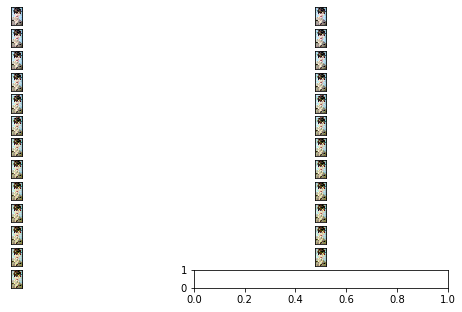

In [61]:
#%matplotlib inline
plt.figure(figsize=(10,10))

for i in range(0,25):
    plt.subplot(5,5,i+1)
    display_image(generated_images[i])
plt.show()

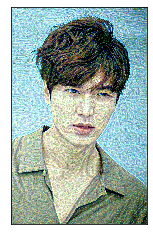

In [109]:
display_image(best_image)

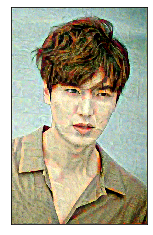

In [94]:
display_image(best_image)

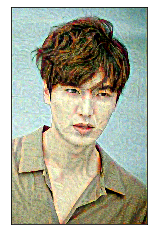

In [90]:
display_image(best_image)

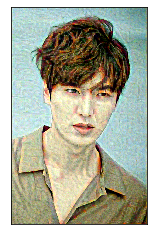

In [84]:
display_image(best_image)

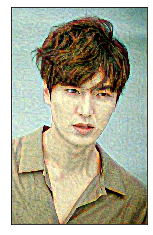

In [77]:
display_image(best_image)

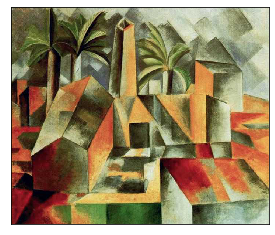

In [78]:
display_image(load_and_process_image('style.jpg'))

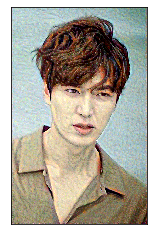

In [70]:
display_image(best_image)

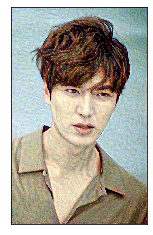

In [64]:
display_image(best_image)

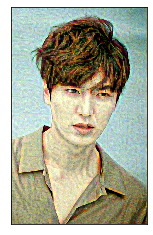

In [60]:
display_image(best_image)

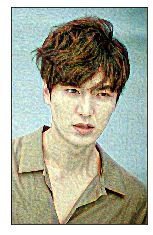

In [57]:
display_image(best_image)

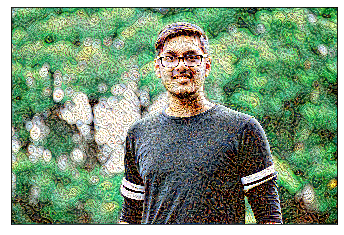

In [16]:
display_image(best_image)

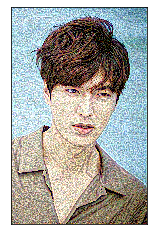

In [42]:
display_image(best_image)

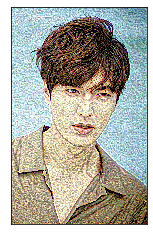

In [54]:
display_image(best_image)

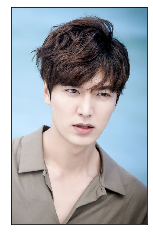

In [73]:
display_image(load_and_process_image('content3.jpg'))